In [1]:
import pandas as pd
import numpy as np
import matplotlib as pl
import matplotlib.pyplot as plt 
import mpl_toolkits.basemap as bm
%matplotlib inline

In [4]:
df = pd.concat([pd.read_csv("./data/2015-11-08.csv"), pd.read_csv("./data/2014-09-26.csv")])

In [5]:
df.dropna(inplace=True)
df = df[df["longitude"] > -76] #Eliminating the  outliers from Pennsylvania!
df.head()

,longitude,latitude,YR,MO,X,Y,TOT,CR
0,-73.891805,40.816361,2015,1,1014198,236718,1,BURGLARY
1,-73.985449,40.778476,2015,1,988280,222897,1,FELONY ASSAULT
2,-74.007940,40.714928,2015,4,982049,199744,1,GRAND LARCENY
3,-73.881708,40.673992,2015,3,1017063,184852,1,ROBBERY
4,-73.947949,40.814580,2015,7,998658,236055,1,ROBBERY


In [6]:
grouped = df.groupby(['CR'])
print grouped.groups.keys()[:10]

['FELONY ASSAULT', 'MURDER', 'GRAND LARCENY OF MOTOR VEHICLE', 'ROBBERY', 'BURGLARY', 'GRAND LARCENY', 'RAPE']


CR
MURDER                              437
RAPE                                856
GRAND LARCENY OF MOTOR VEHICLE    10112
BURGLARY                          20015
ROBBERY                           21462
FELONY ASSAULT                    24600
GRAND LARCENY                     50713
dtype: int64


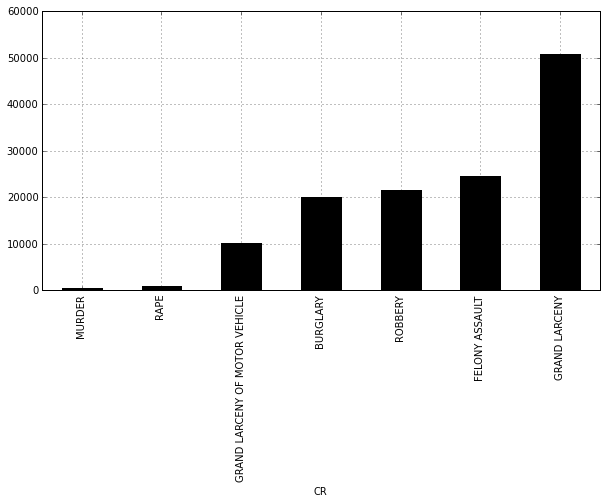

In [7]:
crime_types = df.groupby(['CR']).size()
crime_types.sort()
fig = plt.figure(figsize=(10,5)) #sets size to future figure, optional
crime_types.plot(kind='bar', color='k')
print crime_types

In [8]:

coords = (
           df["longitude"].min(), df["latitude"].min(),
           df["longitude"].max(), df["latitude"].max(),
        )

w, h = coords[2] - coords[0], coords[3] - coords[1]

m = bm.Basemap(
    projection='tmerc',
    lon_0=-74.130559,
    lat_0=40.703493,
    ellps = 'WGS84',
    llcrnrlon=coords[0],
    llcrnrlat=coords[1],
    urcrnrlon=coords[2],
    urcrnrlat=coords[3],
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)


(195,
 5,
 [-74.25559136315213, 40.496115395168516, 0.0, 0.0],
 [-73.70000906321046, 40.915532776502616, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fe780b1aa10>)

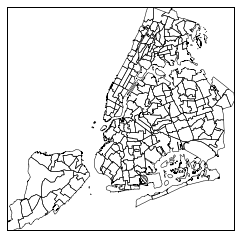

In [9]:
m.readshapefile(
    './data/ny/ny',
    'NY',
    zorder=2)


In [10]:
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
#print m.NY_info
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.NY],
    })
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

In [11]:
from descartes import PolygonPatch
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    zorder=4
    ))


In [12]:
def get_marker_by_name(name):
    crimes = sorted(grouped.groups.keys())
    
    colors = ["green", "red", "yellow", "gray", "brown", "black", "pink"]
    shapes = ['o', 'v', '^', '<', '>', 's', 'p']
    
    d = {}
    for t in zip(crimes, colors, shapes):
        d[t[0]] = (t[1], t[2])
    
    if name not in d:
        return ("white", "8")
    
    return d[name]

    

In [13]:
def draw_points(series, name = "", color = "green", max_num = None):
    if max_num is not None:
        series = series[:max_num]
    
    color, shape = get_marker_by_name(name)
    default_size = 30
    res = m.scatter(
        [p for p in series["longitude"]],
        [p for p in series["latitude"]],
        s=default_size,
        marker=shape, 
        facecolor=color, 
        latlon=True,
        label=name, 
        zorder=1,
    )
    return res

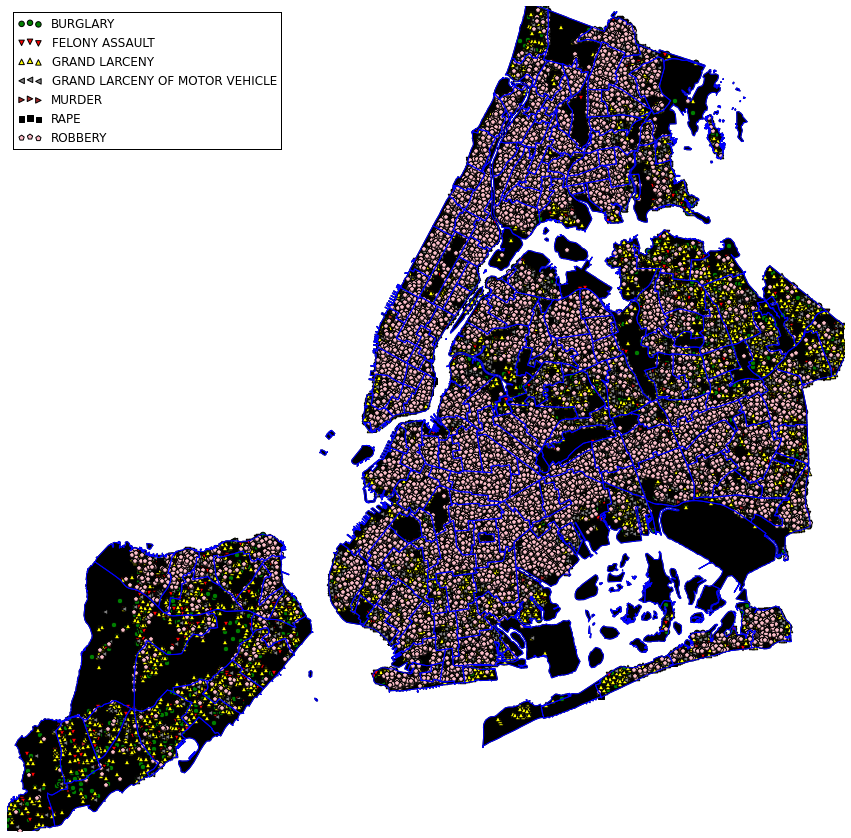

In [14]:
from matplotlib.collections import PatchCollection
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

#for administrative boundaries
for info, shape in zip(m.NY_info, m.NY):
          x, y = zip(*shape) 
          m.plot(x, y,color='b')

#for ground
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True)) 

for idx,  groupdata in enumerate(grouped):
    name, group = groupdata
    res = draw_points(group, name = name)
    plt.legend(loc=0)


fig.set_size_inches(15,15)
